In [1]:
# PACS details
domains = ['photo', 'art_painting', 'cartoon', 'sketch']
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse','house', 'person']

# Set parameters

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torchvision.datasets as Datasets
from torchvision import models
from torchvision.datasets import ImageFolder, DatasetFolder

from utils import *
import os

import numpy as np
import matplotlib.pyplot as plt

from model.resnet18_selfreg import resnet18


In [3]:
##############################
# Training Setting
##############################

# Select model to train
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'
save_name = 'SelfReg_official_test'     # save_dir name
                                        # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = 'pacs_official_split' 
number_of_tests = 1
gpu_num = 1
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

is_selfreg = True  # use selfreg?
is_idcl = True # use IDCL?

epochs = 30
batch_size = 128
is_pretrained = True  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'

#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)


In [4]:
device = torch.device("cpu")
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda:{}".format(gpu_num))
print(device)

# save settings
model_settings = {
    "used_model": used_model,
    "dataset": dataset,
    "save_name": save_name,
    "pacs_ver": pacs_ver,
    "number_of_tests": number_of_tests,
    "epochs": epochs,
    "batch_size": batch_size,
    "is_pretrained": is_pretrained,
    "lr": lr,
    "lr_decay_epoch": lr_decay_epoch,
    "lr_decay_gamma": lr_decay_gamma,
    "gpu_num": gpu_num,
}

criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.NLLloss().to(device)

Using CUDA
cuda:1


# Functions

In [5]:

def classic_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
):

    train_set1 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set2 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set3 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=train_tf,
    )

    val_set1 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set2 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set3 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=test_tf,
    )

    train_set = train_set1 + train_set2 + train_set3
    val_set = val_set1 + val_set2 + val_set3
    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )

    if used_model == "vgg16":
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = len(classes)
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = len(classes)
        model.fc.out_features = len(classes)
    # 해당 코드 바꾸면 될듯? resnet18 부분..
    elif used_model == "resnet18":
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    settings = {
        "train_loaders": train_loader,
        "val_loaders": val_loader,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader


def IDCL_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
):

    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3

    for i in range(4):
        if check > check_limit:
            break
        if i == test_domain_idx:
            continue

        temp = ImageFolder(
            root=os.path.join("{}/train".format(pacs_ver), domains[i]),
            transform=train_tf,
        )

        temp_val = ImageFolder(
            root=os.path.join("{}/val".format(pacs_ver), domains[i]), transform=test_tf
        )
        if check == 1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val

        if check == 1:
            train_set_stage1 = train_set
            val_set_stage1 = val_set
        elif check == 2:
            train_set_stage2 = train_set
            val_set_stage2 = val_set
        elif check == 3:
            train_set_stage3 = train_set
            val_set_stage3 = val_set

        check += 1

    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    print("stage1 (train,val):", len(train_set_stage1), len(val_set_stage1))
    print("stage2 (train,val):", len(train_set_stage2), len(val_set_stage2))
    print("stage3 (train,val):", len(train_set_stage3), len(val_set_stage3))
    print("test :", len(test_set))

    t_loader1 = DataLoader(
        train_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader1 = DataLoader(
        val_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader2 = DataLoader(
        train_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader2 = DataLoader(
        val_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader3 = DataLoader(
        train_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader3 = DataLoader(
        val_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )

    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=6
    )

    if used_model == "vgg16":
        print("vgg16")
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = 7
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features = 7
    elif used_model == "resnet18":
        model = resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    train_loaders = [t_loader1, t_loader2, t_loader3]
    val_loaders = [v_loader1, v_loader2, v_loader3]

    settings = {
        "train_loaders": train_loaders,
        "val_loaders": val_loaders,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader



# Automation

stage1 (train,val): 1499 171
stage2 (train,val): 3339 379
stage3 (train,val): 5446 616
test : 3929
save_dir resnet18/pacs/SelfReg_official_test/photo+art_painting+cartoon(sketch)/
Epoch: 1 [128/1499 (9%)],	Accuracy: 0.0%,  	 Loss: 6.6397
Epoch: 1 [256/1499 (17%)],	Accuracy: 0.8%,  	 Loss: 6.5817
Epoch: 1 [384/1499 (26%)],	Accuracy: 2.3%,  	 Loss: 6.3818
Epoch: 1 [512/1499 (34%)],	Accuracy: 35.9%,  	 Loss: 6.0329
Epoch: 1 [640/1499 (43%)],	Accuracy: 46.1%,  	 Loss: 5.6583
Epoch: 1 [768/1499 (51%)],	Accuracy: 29.7%,  	 Loss: 5.4190
Epoch: 1 [896/1499 (60%)],	Accuracy: 29.7%,  	 Loss: 4.9077
Epoch: 1 [1024/1499 (68%)],	Accuracy: 39.8%,  	 Loss: 4.3224
Epoch: 1 [1152/1499 (77%)],	Accuracy: 27.3%,  	 Loss: 4.0475
Epoch: 1 [1280/1499 (85%)],	Accuracy: 24.2%,  	 Loss: 3.7784
Epoch: 1 [1408/1499 (94%)],	Accuracy: 21.1%,  	 Loss: 3.4479
Epoch: 1 [1499/1499 (100%)],	Accuracy: 22.0%,  	 Loss: 3.3205
loss_val: 5.342744827270508 171
acc_val: 44 171
Validation =======================================

Epoch: 8 [384/3339 (12%)],	Accuracy: 81.2%,  	 Loss: 0.8100
Epoch: 8 [512/3339 (15%)],	Accuracy: 84.4%,  	 Loss: 0.7907
Epoch: 8 [640/3339 (19%)],	Accuracy: 76.6%,  	 Loss: 0.9289
Epoch: 8 [768/3339 (23%)],	Accuracy: 77.3%,  	 Loss: 0.8434
Epoch: 8 [896/3339 (27%)],	Accuracy: 85.2%,  	 Loss: 0.7068
Epoch: 8 [1024/3339 (31%)],	Accuracy: 78.9%,  	 Loss: 0.8292
Epoch: 8 [1152/3339 (35%)],	Accuracy: 80.5%,  	 Loss: 0.8251
Epoch: 8 [1280/3339 (38%)],	Accuracy: 78.9%,  	 Loss: 0.7633
Epoch: 8 [1408/3339 (42%)],	Accuracy: 85.9%,  	 Loss: 0.7670
Epoch: 8 [1536/3339 (46%)],	Accuracy: 81.2%,  	 Loss: 0.7513
Epoch: 8 [1664/3339 (50%)],	Accuracy: 82.0%,  	 Loss: 0.7231
Epoch: 8 [1792/3339 (54%)],	Accuracy: 82.8%,  	 Loss: 0.7635
Epoch: 8 [1920/3339 (58%)],	Accuracy: 82.8%,  	 Loss: 0.7237
Epoch: 8 [2048/3339 (61%)],	Accuracy: 86.7%,  	 Loss: 0.6789
Epoch: 8 [2176/3339 (65%)],	Accuracy: 87.5%,  	 Loss: 0.6582
Epoch: 8 [2304/3339 (69%)],	Accuracy: 83.6%,  	 Loss: 0.6857
Epoch: 8 [2432/3339 (73%)],	A

Epoch: 12 [384/5446 (7%)],	Accuracy: 83.6%,  	 Loss: 0.5494
Epoch: 12 [512/5446 (9%)],	Accuracy: 88.3%,  	 Loss: 0.4933
Epoch: 12 [640/5446 (12%)],	Accuracy: 85.9%,  	 Loss: 0.4721
Epoch: 12 [768/5446 (14%)],	Accuracy: 88.3%,  	 Loss: 0.4817
Epoch: 12 [896/5446 (16%)],	Accuracy: 81.2%,  	 Loss: 0.5845
Epoch: 12 [1024/5446 (19%)],	Accuracy: 90.6%,  	 Loss: 0.4794
Epoch: 12 [1152/5446 (21%)],	Accuracy: 87.5%,  	 Loss: 0.5449
Epoch: 12 [1280/5446 (24%)],	Accuracy: 82.0%,  	 Loss: 0.5776
Epoch: 12 [1408/5446 (26%)],	Accuracy: 77.3%,  	 Loss: 0.6383
Epoch: 12 [1536/5446 (28%)],	Accuracy: 86.7%,  	 Loss: 0.5006
Epoch: 12 [1664/5446 (31%)],	Accuracy: 79.7%,  	 Loss: 0.6087
Epoch: 12 [1792/5446 (33%)],	Accuracy: 89.1%,  	 Loss: 0.4601
Epoch: 12 [1920/5446 (35%)],	Accuracy: 82.8%,  	 Loss: 0.5747
Epoch: 12 [2048/5446 (38%)],	Accuracy: 86.7%,  	 Loss: 0.5516
Epoch: 12 [2176/5446 (40%)],	Accuracy: 87.5%,  	 Loss: 0.4879
Epoch: 12 [2304/5446 (42%)],	Accuracy: 79.7%,  	 Loss: 0.5794
Epoch: 12 [2432

Epoch: 15 [128/5446 (2%)],	Accuracy: 89.1%,  	 Loss: 0.3281
Epoch: 15 [256/5446 (5%)],	Accuracy: 93.0%,  	 Loss: 0.3427
Epoch: 15 [384/5446 (7%)],	Accuracy: 93.8%,  	 Loss: 0.3065
Epoch: 15 [512/5446 (9%)],	Accuracy: 91.4%,  	 Loss: 0.3468
Epoch: 15 [640/5446 (12%)],	Accuracy: 86.7%,  	 Loss: 0.4201
Epoch: 15 [768/5446 (14%)],	Accuracy: 85.9%,  	 Loss: 0.3739
Epoch: 15 [896/5446 (16%)],	Accuracy: 81.2%,  	 Loss: 0.5041
Epoch: 15 [1024/5446 (19%)],	Accuracy: 88.3%,  	 Loss: 0.3335
Epoch: 15 [1152/5446 (21%)],	Accuracy: 91.4%,  	 Loss: 0.3224
Epoch: 15 [1280/5446 (24%)],	Accuracy: 91.4%,  	 Loss: 0.3049
Epoch: 15 [1408/5446 (26%)],	Accuracy: 91.4%,  	 Loss: 0.3044
Epoch: 15 [1536/5446 (28%)],	Accuracy: 89.8%,  	 Loss: 0.3631
Epoch: 15 [1664/5446 (31%)],	Accuracy: 92.2%,  	 Loss: 0.3261
Epoch: 15 [1792/5446 (33%)],	Accuracy: 91.4%,  	 Loss: 0.2989
Epoch: 15 [1920/5446 (35%)],	Accuracy: 93.8%,  	 Loss: 0.2824
Epoch: 15 [2048/5446 (38%)],	Accuracy: 89.8%,  	 Loss: 0.3756
Epoch: 15 [2176/544

Epoch: 17 [5446/5446 (100%)],	Accuracy: 88.6%,  	 Loss: 0.3100
loss_val: 1.4851205050945282 616
acc_val: 567 616
Validation ==================================================
Avg loss (val): 0.0024
Avg acc (val): 0.9205

Epoch: 18 [128/5446 (2%)],	Accuracy: 92.2%,  	 Loss: 0.2925
Epoch: 18 [256/5446 (5%)],	Accuracy: 91.4%,  	 Loss: 0.2625
Epoch: 18 [384/5446 (7%)],	Accuracy: 96.1%,  	 Loss: 0.2514
Epoch: 18 [512/5446 (9%)],	Accuracy: 89.8%,  	 Loss: 0.2776
Epoch: 18 [640/5446 (12%)],	Accuracy: 95.3%,  	 Loss: 0.1786
Epoch: 18 [768/5446 (14%)],	Accuracy: 93.0%,  	 Loss: 0.2621
Epoch: 18 [896/5446 (16%)],	Accuracy: 94.5%,  	 Loss: 0.2335
Epoch: 18 [1024/5446 (19%)],	Accuracy: 93.8%,  	 Loss: 0.2435
Epoch: 18 [1152/5446 (21%)],	Accuracy: 86.7%,  	 Loss: 0.3678
Epoch: 18 [1280/5446 (24%)],	Accuracy: 92.2%,  	 Loss: 0.2215
Epoch: 18 [1408/5446 (26%)],	Accuracy: 89.8%,  	 Loss: 0.2651
Epoch: 18 [1536/5446 (28%)],	Accuracy: 92.2%,  	 Loss: 0.2542
Epoch: 18 [1664/5446 (31%)],	Accuracy: 83.6%, 

Epoch: 20 [4992/5446 (92%)],	Accuracy: 87.5%,  	 Loss: 0.3232
Epoch: 20 [5120/5446 (94%)],	Accuracy: 93.0%,  	 Loss: 0.1895
Epoch: 20 [5248/5446 (96%)],	Accuracy: 86.7%,  	 Loss: 0.4267
Epoch: 20 [5376/5446 (99%)],	Accuracy: 89.8%,  	 Loss: 0.3004
Epoch: 20 [5446/5446 (100%)],	Accuracy: 92.9%,  	 Loss: 0.2350
loss_val: 1.3478974997997284 616
acc_val: 568 616
Validation ==================================================
Avg loss (val): 0.0022
Avg acc (val): 0.9221

Epoch: 21 [128/5446 (2%)],	Accuracy: 94.5%,  	 Loss: 0.1699
Epoch: 21 [256/5446 (5%)],	Accuracy: 93.0%,  	 Loss: 0.2427
Epoch: 21 [384/5446 (7%)],	Accuracy: 92.2%,  	 Loss: 0.2075
Epoch: 21 [512/5446 (9%)],	Accuracy: 89.8%,  	 Loss: 0.2560
Epoch: 21 [640/5446 (12%)],	Accuracy: 93.8%,  	 Loss: 0.2214
Epoch: 21 [768/5446 (14%)],	Accuracy: 93.8%,  	 Loss: 0.1959
Epoch: 21 [896/5446 (16%)],	Accuracy: 93.8%,  	 Loss: 0.2128
Epoch: 21 [1024/5446 (19%)],	Accuracy: 96.9%,  	 Loss: 0.1898
Epoch: 21 [1152/5446 (21%)],	Accuracy: 91.4%, 

Epoch: 23 [4480/5446 (82%)],	Accuracy: 90.6%,  	 Loss: 0.2511
Epoch: 23 [4608/5446 (85%)],	Accuracy: 90.6%,  	 Loss: 0.2386
Epoch: 23 [4736/5446 (87%)],	Accuracy: 92.2%,  	 Loss: 0.2139
Epoch: 23 [4864/5446 (89%)],	Accuracy: 93.0%,  	 Loss: 0.2414
Epoch: 23 [4992/5446 (92%)],	Accuracy: 91.4%,  	 Loss: 0.2402
Epoch: 23 [5120/5446 (94%)],	Accuracy: 93.0%,  	 Loss: 0.2035
Epoch: 23 [5248/5446 (96%)],	Accuracy: 92.2%,  	 Loss: 0.2071
Epoch: 23 [5376/5446 (99%)],	Accuracy: 93.0%,  	 Loss: 0.2569
Epoch: 23 [5446/5446 (100%)],	Accuracy: 95.7%,  	 Loss: 0.1848
loss_val: 1.2375594973564148 616
acc_val: 570 616
Validation ==================================================
Avg loss (val): 0.0020
Avg acc (val): 0.9253

Epoch: 24 [128/5446 (2%)],	Accuracy: 92.2%,  	 Loss: 0.2191
Epoch: 24 [256/5446 (5%)],	Accuracy: 95.3%,  	 Loss: 0.1765
Epoch: 24 [384/5446 (7%)],	Accuracy: 95.3%,  	 Loss: 0.1472
Epoch: 24 [512/5446 (9%)],	Accuracy: 93.8%,  	 Loss: 0.1986
Epoch: 24 [640/5446 (12%)],	Accuracy: 96.1%

Epoch: 26 [3968/5446 (73%)],	Accuracy: 94.5%,  	 Loss: 0.1671
Epoch: 26 [4096/5446 (75%)],	Accuracy: 93.0%,  	 Loss: 0.2097
Epoch: 26 [4224/5446 (78%)],	Accuracy: 93.0%,  	 Loss: 0.1891
Epoch: 26 [4352/5446 (80%)],	Accuracy: 93.8%,  	 Loss: 0.2165
Epoch: 26 [4480/5446 (82%)],	Accuracy: 96.1%,  	 Loss: 0.1196
Epoch: 26 [4608/5446 (85%)],	Accuracy: 94.5%,  	 Loss: 0.1652
Epoch: 26 [4736/5446 (87%)],	Accuracy: 90.6%,  	 Loss: 0.2273
Epoch: 26 [4864/5446 (89%)],	Accuracy: 95.3%,  	 Loss: 0.2045
Epoch: 26 [4992/5446 (92%)],	Accuracy: 92.2%,  	 Loss: 0.2086
Epoch: 26 [5120/5446 (94%)],	Accuracy: 91.4%,  	 Loss: 0.2329
Epoch: 26 [5248/5446 (96%)],	Accuracy: 89.8%,  	 Loss: 0.3032
Epoch: 26 [5376/5446 (99%)],	Accuracy: 92.2%,  	 Loss: 0.1944
Epoch: 26 [5446/5446 (100%)],	Accuracy: 94.3%,  	 Loss: 0.1753
loss_val: 1.1562547385692596 616
acc_val: 577 616
Validation ==================================================
Avg loss (val): 0.0019
Avg acc (val): 0.9367

Epoch: 27 [128/5446 (2%)],	Accuracy

Epoch: 29 [3456/5446 (63%)],	Accuracy: 96.9%,  	 Loss: 0.1388
Epoch: 29 [3584/5446 (66%)],	Accuracy: 94.5%,  	 Loss: 0.1627
Epoch: 29 [3712/5446 (68%)],	Accuracy: 96.9%,  	 Loss: 0.1324
Epoch: 29 [3840/5446 (71%)],	Accuracy: 94.5%,  	 Loss: 0.1712
Epoch: 29 [3968/5446 (73%)],	Accuracy: 95.3%,  	 Loss: 0.1345
Epoch: 29 [4096/5446 (75%)],	Accuracy: 98.4%,  	 Loss: 0.0957
Epoch: 29 [4224/5446 (78%)],	Accuracy: 94.5%,  	 Loss: 0.1623
Epoch: 29 [4352/5446 (80%)],	Accuracy: 94.5%,  	 Loss: 0.1588
Epoch: 29 [4480/5446 (82%)],	Accuracy: 93.0%,  	 Loss: 0.2112
Epoch: 29 [4608/5446 (85%)],	Accuracy: 93.0%,  	 Loss: 0.2073
Epoch: 29 [4736/5446 (87%)],	Accuracy: 96.9%,  	 Loss: 0.1275
Epoch: 29 [4864/5446 (89%)],	Accuracy: 93.8%,  	 Loss: 0.1456
Epoch: 29 [4992/5446 (92%)],	Accuracy: 93.8%,  	 Loss: 0.1577
Epoch: 29 [5120/5446 (94%)],	Accuracy: 96.1%,  	 Loss: 0.1323
Epoch: 29 [5248/5446 (96%)],	Accuracy: 96.1%,  	 Loss: 0.1635
Epoch: 29 [5376/5446 (99%)],	Accuracy: 96.1%,  	 Loss: 0.1351
Epoch: 2

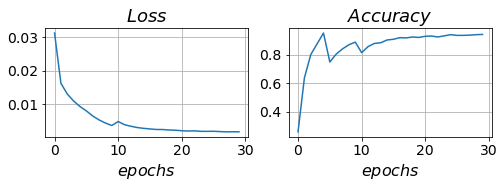

stage1 (train,val): 1499 171
stage2 (train,val): 3339 379
stage3 (train,val): 6870 777
test : 2344
save_dir resnet18/pacs/SelfReg_official_test/photo+art_painting+sketch(cartoon)/
Epoch: 1 [128/1499 (9%)],	Accuracy: 0.0%,  	 Loss: 6.8917
Epoch: 1 [256/1499 (17%)],	Accuracy: 0.0%,  	 Loss: 6.7890
Epoch: 1 [384/1499 (26%)],	Accuracy: 0.8%,  	 Loss: 6.6149
Epoch: 1 [512/1499 (34%)],	Accuracy: 16.4%,  	 Loss: 6.2730
Epoch: 1 [640/1499 (43%)],	Accuracy: 30.5%,  	 Loss: 5.8681
Epoch: 1 [768/1499 (51%)],	Accuracy: 21.9%,  	 Loss: 5.6245
Epoch: 1 [896/1499 (60%)],	Accuracy: 25.8%,  	 Loss: 5.1538
Epoch: 1 [1024/1499 (68%)],	Accuracy: 29.7%,  	 Loss: 4.6530
Epoch: 1 [1152/1499 (77%)],	Accuracy: 28.1%,  	 Loss: 4.2076
Epoch: 1 [1280/1499 (85%)],	Accuracy: 21.9%,  	 Loss: 3.8911
Epoch: 1 [1408/1499 (94%)],	Accuracy: 25.8%,  	 Loss: 3.5826
Epoch: 1 [1499/1499 (100%)],	Accuracy: 24.2%,  	 Loss: 3.1857
loss_val: 5.696277379989624 171
acc_val: 44 171
Validation =======================================

Epoch: 8 [384/3339 (12%)],	Accuracy: 81.2%,  	 Loss: 0.7980
Epoch: 8 [512/3339 (15%)],	Accuracy: 75.8%,  	 Loss: 0.8880
Epoch: 8 [640/3339 (19%)],	Accuracy: 76.6%,  	 Loss: 0.8208
Epoch: 8 [768/3339 (23%)],	Accuracy: 78.9%,  	 Loss: 0.8166
Epoch: 8 [896/3339 (27%)],	Accuracy: 75.8%,  	 Loss: 0.8187
Epoch: 8 [1024/3339 (31%)],	Accuracy: 80.5%,  	 Loss: 0.7687
Epoch: 8 [1152/3339 (35%)],	Accuracy: 82.8%,  	 Loss: 0.7139
Epoch: 8 [1280/3339 (38%)],	Accuracy: 81.2%,  	 Loss: 0.7856
Epoch: 8 [1408/3339 (42%)],	Accuracy: 82.8%,  	 Loss: 0.7098
Epoch: 8 [1536/3339 (46%)],	Accuracy: 84.4%,  	 Loss: 0.7258
Epoch: 8 [1664/3339 (50%)],	Accuracy: 85.9%,  	 Loss: 0.7558
Epoch: 8 [1792/3339 (54%)],	Accuracy: 83.6%,  	 Loss: 0.7510
Epoch: 8 [1920/3339 (58%)],	Accuracy: 84.4%,  	 Loss: 0.7870
Epoch: 8 [2048/3339 (61%)],	Accuracy: 81.2%,  	 Loss: 0.7810
Epoch: 8 [2176/3339 (65%)],	Accuracy: 82.0%,  	 Loss: 0.7470
Epoch: 8 [2304/3339 (69%)],	Accuracy: 86.7%,  	 Loss: 0.7028
Epoch: 8 [2432/3339 (73%)],	A

Epoch: 11 [6272/6870 (91%)],	Accuracy: 79.7%,  	 Loss: 0.6431
Epoch: 11 [6400/6870 (93%)],	Accuracy: 73.4%,  	 Loss: 0.7154
Epoch: 11 [6528/6870 (95%)],	Accuracy: 73.4%,  	 Loss: 0.7397
Epoch: 11 [6656/6870 (97%)],	Accuracy: 85.9%,  	 Loss: 0.5499
Epoch: 11 [6784/6870 (99%)],	Accuracy: 82.8%,  	 Loss: 0.6172
Epoch: 11 [6870/6870 (100%)],	Accuracy: 76.7%,  	 Loss: 0.7079
loss_val: 4.0856627225875854 777
acc_val: 649 777
Validation ==================================================
Avg loss (val): 0.0053
Avg acc (val): 0.8353

Epoch: 12 [128/6870 (2%)],	Accuracy: 85.2%,  	 Loss: 0.5733
Epoch: 12 [256/6870 (4%)],	Accuracy: 86.7%,  	 Loss: 0.5600
Epoch: 12 [384/6870 (6%)],	Accuracy: 82.8%,  	 Loss: 0.5675
Epoch: 12 [512/6870 (7%)],	Accuracy: 78.1%,  	 Loss: 0.7494
Epoch: 12 [640/6870 (9%)],	Accuracy: 82.8%,  	 Loss: 0.5428
Epoch: 12 [768/6870 (11%)],	Accuracy: 80.5%,  	 Loss: 0.6072
Epoch: 12 [896/6870 (13%)],	Accuracy: 86.7%,  	 Loss: 0.4541
Epoch: 12 [1024/6870 (15%)],	Accuracy: 82.0%,  

Epoch: 14 [1664/6870 (24%)],	Accuracy: 93.0%,  	 Loss: 0.3508
Epoch: 14 [1792/6870 (26%)],	Accuracy: 87.5%,  	 Loss: 0.3427
Epoch: 14 [1920/6870 (28%)],	Accuracy: 84.4%,  	 Loss: 0.3729
Epoch: 14 [2048/6870 (30%)],	Accuracy: 92.2%,  	 Loss: 0.2810
Epoch: 14 [2176/6870 (32%)],	Accuracy: 88.3%,  	 Loss: 0.3590
Epoch: 14 [2304/6870 (34%)],	Accuracy: 88.3%,  	 Loss: 0.3350
Epoch: 14 [2432/6870 (35%)],	Accuracy: 93.0%,  	 Loss: 0.3009
Epoch: 14 [2560/6870 (37%)],	Accuracy: 89.8%,  	 Loss: 0.3000
Epoch: 14 [2688/6870 (39%)],	Accuracy: 86.7%,  	 Loss: 0.4675
Epoch: 14 [2816/6870 (41%)],	Accuracy: 90.6%,  	 Loss: 0.3399
Epoch: 14 [2944/6870 (43%)],	Accuracy: 86.7%,  	 Loss: 0.3891
Epoch: 14 [3072/6870 (45%)],	Accuracy: 90.6%,  	 Loss: 0.3434
Epoch: 14 [3200/6870 (47%)],	Accuracy: 88.3%,  	 Loss: 0.3438
Epoch: 14 [3328/6870 (48%)],	Accuracy: 89.8%,  	 Loss: 0.3418
Epoch: 14 [3456/6870 (50%)],	Accuracy: 92.2%,  	 Loss: 0.3021
Epoch: 14 [3584/6870 (52%)],	Accuracy: 91.4%,  	 Loss: 0.2983
Epoch: 1

Epoch: 16 [4224/6870 (61%)],	Accuracy: 91.4%,  	 Loss: 0.2592
Epoch: 16 [4352/6870 (63%)],	Accuracy: 93.0%,  	 Loss: 0.2437
Epoch: 16 [4480/6870 (65%)],	Accuracy: 93.8%,  	 Loss: 0.2399
Epoch: 16 [4608/6870 (67%)],	Accuracy: 93.8%,  	 Loss: 0.2548
Epoch: 16 [4736/6870 (69%)],	Accuracy: 93.8%,  	 Loss: 0.2396
Epoch: 16 [4864/6870 (71%)],	Accuracy: 94.5%,  	 Loss: 0.2298
Epoch: 16 [4992/6870 (73%)],	Accuracy: 87.5%,  	 Loss: 0.3531
Epoch: 16 [5120/6870 (75%)],	Accuracy: 86.7%,  	 Loss: 0.3467
Epoch: 16 [5248/6870 (76%)],	Accuracy: 94.5%,  	 Loss: 0.2573
Epoch: 16 [5376/6870 (78%)],	Accuracy: 89.8%,  	 Loss: 0.3021
Epoch: 16 [5504/6870 (80%)],	Accuracy: 93.0%,  	 Loss: 0.2400
Epoch: 16 [5632/6870 (82%)],	Accuracy: 94.5%,  	 Loss: 0.2650
Epoch: 16 [5760/6870 (84%)],	Accuracy: 87.5%,  	 Loss: 0.4142
Epoch: 16 [5888/6870 (86%)],	Accuracy: 94.5%,  	 Loss: 0.2218
Epoch: 16 [6016/6870 (88%)],	Accuracy: 95.3%,  	 Loss: 0.2058
Epoch: 16 [6144/6870 (89%)],	Accuracy: 89.8%,  	 Loss: 0.3184
Epoch: 1

Epoch: 18 [6784/6870 (99%)],	Accuracy: 91.4%,  	 Loss: 0.2643
Epoch: 18 [6870/6870 (100%)],	Accuracy: 91.9%,  	 Loss: 0.2480
loss_val: 2.5051734000444412 777
acc_val: 718 777
Validation ==================================================
Avg loss (val): 0.0032
Avg acc (val): 0.9241

Epoch: 19 [128/6870 (2%)],	Accuracy: 93.0%,  	 Loss: 0.1913
Epoch: 19 [256/6870 (4%)],	Accuracy: 96.9%,  	 Loss: 0.1529
Epoch: 19 [384/6870 (6%)],	Accuracy: 91.4%,  	 Loss: 0.2145
Epoch: 19 [512/6870 (7%)],	Accuracy: 95.3%,  	 Loss: 0.2089
Epoch: 19 [640/6870 (9%)],	Accuracy: 96.1%,  	 Loss: 0.1915
Epoch: 19 [768/6870 (11%)],	Accuracy: 94.5%,  	 Loss: 0.1896
Epoch: 19 [896/6870 (13%)],	Accuracy: 94.5%,  	 Loss: 0.1824
Epoch: 19 [1024/6870 (15%)],	Accuracy: 91.4%,  	 Loss: 0.2292
Epoch: 19 [1152/6870 (17%)],	Accuracy: 89.1%,  	 Loss: 0.2890
Epoch: 19 [1280/6870 (19%)],	Accuracy: 92.2%,  	 Loss: 0.2339
Epoch: 19 [1408/6870 (20%)],	Accuracy: 95.3%,  	 Loss: 0.1799
Epoch: 19 [1536/6870 (22%)],	Accuracy: 92.2%,  

Epoch: 21 [2176/6870 (32%)],	Accuracy: 97.7%,  	 Loss: 0.1438
Epoch: 21 [2304/6870 (34%)],	Accuracy: 94.5%,  	 Loss: 0.2058
Epoch: 21 [2432/6870 (35%)],	Accuracy: 94.5%,  	 Loss: 0.1515
Epoch: 21 [2560/6870 (37%)],	Accuracy: 95.3%,  	 Loss: 0.1576
Epoch: 21 [2688/6870 (39%)],	Accuracy: 92.2%,  	 Loss: 0.2571
Epoch: 21 [2816/6870 (41%)],	Accuracy: 92.2%,  	 Loss: 0.3034
Epoch: 21 [2944/6870 (43%)],	Accuracy: 92.2%,  	 Loss: 0.1874
Epoch: 21 [3072/6870 (45%)],	Accuracy: 90.6%,  	 Loss: 0.2458
Epoch: 21 [3200/6870 (47%)],	Accuracy: 91.4%,  	 Loss: 0.2685
Epoch: 21 [3328/6870 (48%)],	Accuracy: 95.3%,  	 Loss: 0.1576
Epoch: 21 [3456/6870 (50%)],	Accuracy: 93.8%,  	 Loss: 0.1863
Epoch: 21 [3584/6870 (52%)],	Accuracy: 94.5%,  	 Loss: 0.1532
Epoch: 21 [3712/6870 (54%)],	Accuracy: 91.4%,  	 Loss: 0.2571
Epoch: 21 [3840/6870 (56%)],	Accuracy: 94.5%,  	 Loss: 0.1852
Epoch: 21 [3968/6870 (58%)],	Accuracy: 96.1%,  	 Loss: 0.1376
Epoch: 21 [4096/6870 (60%)],	Accuracy: 96.1%,  	 Loss: 0.1392
Epoch: 2

Epoch: 23 [4736/6870 (69%)],	Accuracy: 93.8%,  	 Loss: 0.2112
Epoch: 23 [4864/6870 (71%)],	Accuracy: 94.5%,  	 Loss: 0.1319
Epoch: 23 [4992/6870 (73%)],	Accuracy: 94.5%,  	 Loss: 0.1980
Epoch: 23 [5120/6870 (75%)],	Accuracy: 93.0%,  	 Loss: 0.1580
Epoch: 23 [5248/6870 (76%)],	Accuracy: 96.1%,  	 Loss: 0.1386
Epoch: 23 [5376/6870 (78%)],	Accuracy: 95.3%,  	 Loss: 0.1431
Epoch: 23 [5504/6870 (80%)],	Accuracy: 97.7%,  	 Loss: 0.1187
Epoch: 23 [5632/6870 (82%)],	Accuracy: 95.3%,  	 Loss: 0.1471
Epoch: 23 [5760/6870 (84%)],	Accuracy: 96.1%,  	 Loss: 0.1556
Epoch: 23 [5888/6870 (86%)],	Accuracy: 93.8%,  	 Loss: 0.1870
Epoch: 23 [6016/6870 (88%)],	Accuracy: 93.8%,  	 Loss: 0.1411
Epoch: 23 [6144/6870 (89%)],	Accuracy: 91.4%,  	 Loss: 0.2230
Epoch: 23 [6272/6870 (91%)],	Accuracy: 94.5%,  	 Loss: 0.1521
Epoch: 23 [6400/6870 (93%)],	Accuracy: 93.8%,  	 Loss: 0.1475
Epoch: 23 [6528/6870 (95%)],	Accuracy: 96.1%,  	 Loss: 0.1402
Epoch: 23 [6656/6870 (97%)],	Accuracy: 94.5%,  	 Loss: 0.1797
Epoch: 2

Epoch: 26 [128/6870 (2%)],	Accuracy: 96.1%,  	 Loss: 0.1279
Epoch: 26 [256/6870 (4%)],	Accuracy: 95.3%,  	 Loss: 0.1806
Epoch: 26 [384/6870 (6%)],	Accuracy: 96.1%,  	 Loss: 0.1309
Epoch: 26 [512/6870 (7%)],	Accuracy: 96.1%,  	 Loss: 0.1162
Epoch: 26 [640/6870 (9%)],	Accuracy: 96.9%,  	 Loss: 0.1101
Epoch: 26 [768/6870 (11%)],	Accuracy: 91.4%,  	 Loss: 0.1976
Epoch: 26 [896/6870 (13%)],	Accuracy: 94.5%,  	 Loss: 0.2014
Epoch: 26 [1024/6870 (15%)],	Accuracy: 96.1%,  	 Loss: 0.1793
Epoch: 26 [1152/6870 (17%)],	Accuracy: 98.4%,  	 Loss: 0.0941
Epoch: 26 [1280/6870 (19%)],	Accuracy: 97.7%,  	 Loss: 0.1019
Epoch: 26 [1408/6870 (20%)],	Accuracy: 96.1%,  	 Loss: 0.0990
Epoch: 26 [1536/6870 (22%)],	Accuracy: 93.8%,  	 Loss: 0.1537
Epoch: 26 [1664/6870 (24%)],	Accuracy: 95.3%,  	 Loss: 0.1159
Epoch: 26 [1792/6870 (26%)],	Accuracy: 95.3%,  	 Loss: 0.1284
Epoch: 26 [1920/6870 (28%)],	Accuracy: 92.2%,  	 Loss: 0.2392
Epoch: 26 [2048/6870 (30%)],	Accuracy: 96.1%,  	 Loss: 0.1324
Epoch: 26 [2176/6870

Epoch: 28 [2688/6870 (39%)],	Accuracy: 93.8%,  	 Loss: 0.1317
Epoch: 28 [2816/6870 (41%)],	Accuracy: 94.5%,  	 Loss: 0.1573
Epoch: 28 [2944/6870 (43%)],	Accuracy: 97.7%,  	 Loss: 0.1105
Epoch: 28 [3072/6870 (45%)],	Accuracy: 95.3%,  	 Loss: 0.1225
Epoch: 28 [3200/6870 (47%)],	Accuracy: 95.3%,  	 Loss: 0.1281
Epoch: 28 [3328/6870 (48%)],	Accuracy: 97.7%,  	 Loss: 0.1158
Epoch: 28 [3456/6870 (50%)],	Accuracy: 98.4%,  	 Loss: 0.0907
Epoch: 28 [3584/6870 (52%)],	Accuracy: 96.1%,  	 Loss: 0.1839
Epoch: 28 [3712/6870 (54%)],	Accuracy: 98.4%,  	 Loss: 0.0915
Epoch: 28 [3840/6870 (56%)],	Accuracy: 98.4%,  	 Loss: 0.0774
Epoch: 28 [3968/6870 (58%)],	Accuracy: 93.8%,  	 Loss: 0.1962
Epoch: 28 [4096/6870 (60%)],	Accuracy: 95.3%,  	 Loss: 0.1220
Epoch: 28 [4224/6870 (61%)],	Accuracy: 96.9%,  	 Loss: 0.1564
Epoch: 28 [4352/6870 (63%)],	Accuracy: 98.4%,  	 Loss: 0.0898
Epoch: 28 [4480/6870 (65%)],	Accuracy: 93.8%,  	 Loss: 0.2165
Epoch: 28 [4608/6870 (67%)],	Accuracy: 95.3%,  	 Loss: 0.1220
Epoch: 2

Epoch: 30 [5248/6870 (76%)],	Accuracy: 94.5%,  	 Loss: 0.1649
Epoch: 30 [5376/6870 (78%)],	Accuracy: 96.9%,  	 Loss: 0.0827
Epoch: 30 [5504/6870 (80%)],	Accuracy: 96.1%,  	 Loss: 0.1383
Epoch: 30 [5632/6870 (82%)],	Accuracy: 96.9%,  	 Loss: 0.1191
Epoch: 30 [5760/6870 (84%)],	Accuracy: 93.8%,  	 Loss: 0.1623
Epoch: 30 [5888/6870 (86%)],	Accuracy: 95.3%,  	 Loss: 0.1295
Epoch: 30 [6016/6870 (88%)],	Accuracy: 95.3%,  	 Loss: 0.1368
Epoch: 30 [6144/6870 (89%)],	Accuracy: 97.7%,  	 Loss: 0.0989
Epoch: 30 [6272/6870 (91%)],	Accuracy: 96.9%,  	 Loss: 0.1242
Epoch: 30 [6400/6870 (93%)],	Accuracy: 95.3%,  	 Loss: 0.1701
Epoch: 30 [6528/6870 (95%)],	Accuracy: 96.1%,  	 Loss: 0.1517
Epoch: 30 [6656/6870 (97%)],	Accuracy: 98.4%,  	 Loss: 0.0591
Epoch: 30 [6784/6870 (99%)],	Accuracy: 93.0%,  	 Loss: 0.1535
Epoch: 30 [6870/6870 (100%)],	Accuracy: 94.2%,  	 Loss: 0.2316
loss_val: 1.2648178674280643 777
acc_val: 729 777
Validation ==================================================
Avg loss (val): 0.0

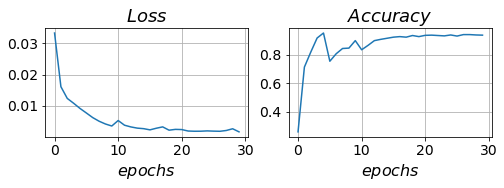

stage1 (train,val): 1499 171
stage2 (train,val): 3606 408
stage3 (train,val): 7137 806
test : 2048
save_dir resnet18/pacs/SelfReg_official_test/photo+cartoon+sketch(art_painting)/
Epoch: 1 [128/1499 (9%)],	Accuracy: 0.0%,  	 Loss: 6.9307
Epoch: 1 [256/1499 (17%)],	Accuracy: 0.0%,  	 Loss: 6.8034
Epoch: 1 [384/1499 (26%)],	Accuracy: 0.8%,  	 Loss: 6.6145
Epoch: 1 [512/1499 (34%)],	Accuracy: 12.5%,  	 Loss: 6.3839
Epoch: 1 [640/1499 (43%)],	Accuracy: 33.6%,  	 Loss: 5.9848
Epoch: 1 [768/1499 (51%)],	Accuracy: 31.2%,  	 Loss: 5.5414
Epoch: 1 [896/1499 (60%)],	Accuracy: 26.6%,  	 Loss: 5.2234
Epoch: 1 [1024/1499 (68%)],	Accuracy: 26.6%,  	 Loss: 4.6923
Epoch: 1 [1152/1499 (77%)],	Accuracy: 32.0%,  	 Loss: 4.2594
Epoch: 1 [1280/1499 (85%)],	Accuracy: 25.8%,  	 Loss: 3.9318
Epoch: 1 [1408/1499 (94%)],	Accuracy: 28.9%,  	 Loss: 3.3965
Epoch: 1 [1499/1499 (100%)],	Accuracy: 31.9%,  	 Loss: 2.9270
loss_val: 5.786543607711792 171
acc_val: 44 171
Validation =======================================

Epoch: 7 [3606/3606 (100%)],	Accuracy: 54.5%,  	 Loss: 1.2313
loss_val: 3.6095070242881775 408
acc_val: 341 408
Validation ==================================================
Avg loss (val): 0.0088
Avg acc (val): 0.8358

Epoch: 8 [128/3606 (4%)],	Accuracy: 82.8%,  	 Loss: 0.9455
Epoch: 8 [256/3606 (7%)],	Accuracy: 78.1%,  	 Loss: 0.9946
Epoch: 8 [384/3606 (11%)],	Accuracy: 82.0%,  	 Loss: 0.8577
Epoch: 8 [512/3606 (14%)],	Accuracy: 75.8%,  	 Loss: 0.9450
Epoch: 8 [640/3606 (18%)],	Accuracy: 85.2%,  	 Loss: 0.8276
Epoch: 8 [768/3606 (21%)],	Accuracy: 78.9%,  	 Loss: 0.9104
Epoch: 8 [896/3606 (25%)],	Accuracy: 78.9%,  	 Loss: 0.8599
Epoch: 8 [1024/3606 (28%)],	Accuracy: 77.3%,  	 Loss: 0.8844
Epoch: 8 [1152/3606 (32%)],	Accuracy: 80.5%,  	 Loss: 0.8446
Epoch: 8 [1280/3606 (35%)],	Accuracy: 82.0%,  	 Loss: 0.7654
Epoch: 8 [1408/3606 (39%)],	Accuracy: 83.6%,  	 Loss: 0.8698
Epoch: 8 [1536/3606 (43%)],	Accuracy: 83.6%,  	 Loss: 0.8707
Epoch: 8 [1664/3606 (46%)],	Accuracy: 85.9%,  	 Loss: 0.8

Epoch: 11 [4736/7137 (66%)],	Accuracy: 82.8%,  	 Loss: 0.6048
Epoch: 11 [4864/7137 (68%)],	Accuracy: 89.1%,  	 Loss: 0.5289
Epoch: 11 [4992/7137 (70%)],	Accuracy: 86.7%,  	 Loss: 0.5783
Epoch: 11 [5120/7137 (72%)],	Accuracy: 83.6%,  	 Loss: 0.5904
Epoch: 11 [5248/7137 (74%)],	Accuracy: 81.2%,  	 Loss: 0.6426
Epoch: 11 [5376/7137 (75%)],	Accuracy: 86.7%,  	 Loss: 0.5664
Epoch: 11 [5504/7137 (77%)],	Accuracy: 77.3%,  	 Loss: 0.7416
Epoch: 11 [5632/7137 (79%)],	Accuracy: 85.2%,  	 Loss: 0.5651
Epoch: 11 [5760/7137 (81%)],	Accuracy: 81.2%,  	 Loss: 0.5809
Epoch: 11 [5888/7137 (82%)],	Accuracy: 86.7%,  	 Loss: 0.5926
Epoch: 11 [6016/7137 (84%)],	Accuracy: 82.8%,  	 Loss: 0.6007
Epoch: 11 [6144/7137 (86%)],	Accuracy: 78.9%,  	 Loss: 0.6401
Epoch: 11 [6272/7137 (88%)],	Accuracy: 78.9%,  	 Loss: 0.6329
Epoch: 11 [6400/7137 (90%)],	Accuracy: 81.2%,  	 Loss: 0.6790
Epoch: 11 [6528/7137 (91%)],	Accuracy: 82.8%,  	 Loss: 0.5540
Epoch: 11 [6656/7137 (93%)],	Accuracy: 78.9%,  	 Loss: 0.6304
Epoch: 1

Epoch: 13 [6784/7137 (95%)],	Accuracy: 82.8%,  	 Loss: 0.4705
Epoch: 13 [6912/7137 (97%)],	Accuracy: 87.5%,  	 Loss: 0.3812
Epoch: 13 [7040/7137 (99%)],	Accuracy: 94.5%,  	 Loss: 0.2952
Epoch: 13 [7137/7137 (100%)],	Accuracy: 86.6%,  	 Loss: 0.4066
loss_val: 2.7753466367721558 806
acc_val: 720 806
Validation ==================================================
Avg loss (val): 0.0034
Avg acc (val): 0.8933

Epoch: 14 [128/7137 (2%)],	Accuracy: 86.7%,  	 Loss: 0.4092
Epoch: 14 [256/7137 (4%)],	Accuracy: 89.8%,  	 Loss: 0.4060
Epoch: 14 [384/7137 (5%)],	Accuracy: 92.2%,  	 Loss: 0.3379
Epoch: 14 [512/7137 (7%)],	Accuracy: 90.6%,  	 Loss: 0.3425
Epoch: 14 [640/7137 (9%)],	Accuracy: 87.5%,  	 Loss: 0.4073
Epoch: 14 [768/7137 (11%)],	Accuracy: 86.7%,  	 Loss: 0.3981
Epoch: 14 [896/7137 (13%)],	Accuracy: 89.8%,  	 Loss: 0.3852
Epoch: 14 [1024/7137 (14%)],	Accuracy: 89.8%,  	 Loss: 0.3195
Epoch: 14 [1152/7137 (16%)],	Accuracy: 88.3%,  	 Loss: 0.4611
Epoch: 14 [1280/7137 (18%)],	Accuracy: 89.8%,  

In [ ]:
is_selfreg = False
save_model_setting(model_settings, used_model, domains, dataset, save_name)
set_train = IDCL_setting if is_idcl else classic_setting
temp_dict = {
    "device": device,
    "epochs": epochs,
    "criterion": criterion,
    "is_selfreg": is_selfreg,
    "is_idcl": is_idcl,
}

for i in range(1, number_of_tests + 1):
    try_check = i

    for test_idx in [3, 2, 1, 0]:

        ##########################
        ####   Setting Train  ####
        ##########################

        model_sets = [
            test_idx,
            domains,
            batch_size,
            is_pretrained,
            train_tf,
            test_tf,
            used_model,
            pacs_ver,
            used_optimizer,
        ]
        train_settings, test_loader = set_train(*model_sets)
        train_settings.update(temp_dict)

        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)
        print("save_dir", save_dir)

        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print("Error : Creating directory. " + save_dir)

        ##########################
        ####     Training     ####
        #####################p#####

        model, losses, accuracies = train(**train_settings)
        test_accuracy = test(
            device, model, criterion, test_loader, used_model, save_dir, try_check
        )

        total_result_text_path = os.path.join(save_dir, "test_total_result.txt")
        with open(total_result_text_path, "a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy) + "\n")

        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
#         save_model(model, used_model, save_dir, is_pretrained, try_check)
        